<a href="https://colab.research.google.com/github/PacktPublishing/Modern-Computer-Vision-with-PyTorch-2E/blob/main/Chapter06/Class_activation_maps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%writefile kaggle.json
{"username":"dh","key":"dh"}

Writing kaggle.json


In [2]:
%pip install -q kaggle torch_snippets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.0/948.0 kB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.1/85.1 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.7/220.7 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 74.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 kB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 79.3 MB/s eta 0:00:00


In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria
!unzip -qq cell-images-for-detecting-malaria.zip

kaggle.json
Dataset URL: https://www.kaggle.com/datasets/iarunava/cell-images-for-detecting-malaria
License(s): unknown
 96% 646M/675M [00:02<00:00, 255MB/s]
100% 675M/675M [00:02<00:00, 290MB/s]


In [4]:
from torch_snippets import *
from torch.utils.data import Dataset

In [5]:
id2int = {'Parasitized': 0, 'Uninfected': 1}

In [6]:
from torchvision import transforms as T

trn_tfms = T.Compose([
    T.ToPILImage(),
    T.Resize(128),
    T.CenterCrop(128),
    T.ColorJitter(brightness=(0.95,1.05),
                  contrast=(0.95,1.05),
                  saturation=(0.95,1.05),
                  hue=0.05),
    T.RandomAffine(5, translate=(0.01,0.1)),
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5],
                std=[0.5, 0.5, 0.5]),
])

In [7]:
val_tfms = T.Compose([
    T.ToPILImage(),
    T.Resize(128),
    T.CenterCrop(128),
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5],
                std=[0.5, 0.5, 0.5]),
])

In [8]:
class MalariaImages(Dataset):

    def __init__(self, files, transform=None):
        self.files = files
        self.transform = transform
        logger.info(len(self))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, ix):
        fpath = self.files[ix]
        clss = fname(parent(fpath))
        img = read(fpath, 1)
        return img, clss

    def choose(self):
        return self[randint(len(self))]

    def collate_fn(self, batch):
        _imgs, classes = list(zip(*batch))
        if self.transform:
            imgs = [self.transform(img)[None] for img in _imgs]
        classes = [torch.tensor([id2int[clss]]) for clss in classes]
        imgs, classes = [torch.cat(i).to(device) for i in [imgs, classes]]
        return imgs, classes, _imgs

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [10]:
# # NameError: name 'torch' is not defined

device = 'cuda' if torch.cuda.is_available() else 'cpu'
all_files = Glob('cell_images/*/*.png')
np.random.seed(10)
np.random.shuffle(all_files)

from sklearn.model_selection import train_test_split
trn_files, val_files = train_test_split(all_files, random_state=1)

trn_ds = MalariaImages(trn_files, transform=trn_tfms)
val_ds = MalariaImages(val_files, transform=val_tfms)
trn_dl = DataLoader(trn_ds, 32, shuffle=True, collate_fn=trn_ds.collate_fn)
val_dl = DataLoader(val_ds, 32, shuffle=False, collate_fn=val_ds.collate_fn)

[06/05/25 04:54:58] INFO     20668                                                                                                 ]8;id=833343;file://<ipython-input-8-6465347be007>:6\<ipython-input-8-6465347be007>]8;;\:]8;id=284097;file://<ipython-input-8-6465347be007>:6#__init__:6\__init__:6]8;;\

                    INFO     6890                                                                                                  ]8;id=712668;file://<ipython-input-8-6465347be007>:6\<ipython-input-8-6465347be007>]8;;\:]8;id=499644;file://<ipython-input-8-6465347be007>:6#__init__:6\__init__:6]8;;\

In [11]:
def convBlock(ni, no):
    return nn.Sequential(
        nn.Dropout(0.2),
        nn.Conv2d(ni, no, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(no),
        nn.MaxPool2d(2),
    )

class MalariaClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            convBlock(3, 64),
            convBlock(64, 64),
            convBlock(64, 128),
            convBlock(128, 256),
            convBlock(256, 512),
            convBlock(512, 64),
            nn.Flatten(),
            nn.Linear(256, 256),
            nn.Dropout(0.2),
            nn.ReLU(inplace=True),
            nn.Linear(256, len(id2int))
        )
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def compute_metrics(self, preds, targets):
        loss = self.loss_fn(preds, targets)
        acc = (torch.max(preds, 1)[1] == targets).float().mean()
        return loss, acc

In [12]:
def train_batch(model, data, optimizer, criterion):
    model.train()
    ims, labels, _ = data
    _preds = model(ims)
    optimizer.zero_grad()
    loss, acc = criterion(_preds, labels)
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
    model.eval()
    ims, labels, _ = data
    _preds = model(ims)
    loss, acc = criterion(_preds, labels)
    return loss.item(), acc.item()

In [19]:
model = MalariaClassifier().to(device)
criterion = model.compute_metrics
optimizer = optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 2

# Initializes empty lists to store training and validation loss and accuracy values
train_losses, train_accs = [], []
val_losses, val_accs = [], []

# Loop 2 epochs (n_epochs)
for ex in range(n_epochs):
    tr_loss, tr_acc = [], []
    for bx, data in enumerate(trn_dl):
        loss, acc = train_batch(model, data, optimizer, criterion)
        tr_loss.append(loss)
        tr_acc.append(acc)

    train_losses.append(sum(tr_loss) / len(tr_loss))
    train_accs.append(sum(tr_acc) / len(tr_acc))

    val_loss, val_acc = [], []
    for bx, data in enumerate(val_dl):
        loss, acc = validate_batch(model, data, criterion)
        val_loss.append(loss)
        val_acc.append(acc)

    val_losses.append(sum(val_loss) / len(val_loss))
    val_accs.append(sum(val_acc) / len(val_acc))

    print(f"Epoch {ex+1}/{n_epochs} → "
          f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accs[-1]:.4f} | "
          f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accs[-1]:.4f}")

Epoch 1/2 → Train Loss: 0.2875, Train Acc: 0.8768 | Val Loss: 0.1666, Val Acc: 0.9466
Epoch 2/2 → Train Loss: 0.1704, Train Acc: 0.9446 | Val Loss: 0.1533, Val Acc: 0.9498


In [20]:
im2fmap = nn.Sequential(*(list(model.model[:5].children()) + list(model.model[5][:2].children())))

In [21]:
def im2gradCAM(x):
    model.eval()
    logits = model(x)
    heatmaps = []
    activations = im2fmap(x)
    print(activations.shape)
    pred = logits.max(-1)[-1]
    # get the model's prediction
    model.zero_grad()
    # compute gradients with respect to model's most confident logit
    logits[0,pred].backward(retain_graph=True)
    # get the gradients at the required featuremap location
    # and take the avg gradient for every featuremap
    pooled_grads = model.model[-6][1].weight.grad.data.mean((1,2,3))
    # multiply each activation map with corresponding gradient average
    for i in range(activations.shape[1]):
        activations[:,i,:,:] *= pooled_grads[i]
    # take the mean of all weighted activation maps
    # (that has been weighted by avg. grad at each fmap)
    heatmap = torch.mean(activations, dim=1)[0].cpu().detach()
    return heatmap, 'Uninfected' if pred.item() else 'Parasitized'

In [22]:
SZ = 128
def upsampleHeatmap(map, img):
    m,M = map.min(), map.max()
    map = 255 * ((map-m) / (M-m))
    map = np.uint8(map)
    map = cv2.resize(map, (SZ,SZ))
    map = cv2.applyColorMap(255-map, cv2.COLORMAP_JET)
    map = np.uint8(map)
    map = np.uint8(map*0.7 + img*0.3)
    return map

In [23]:
import cv2

torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 4, 4])


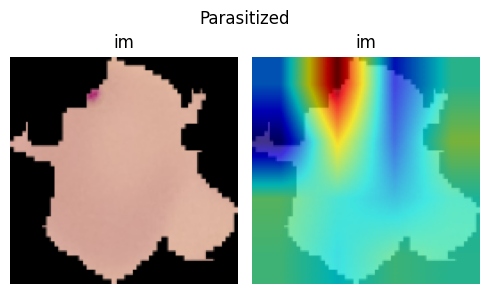

torch.Size([1, 64, 4, 4])


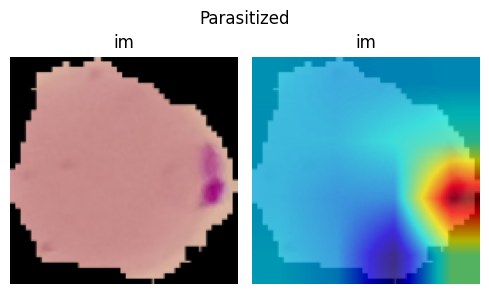

torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 4, 4])


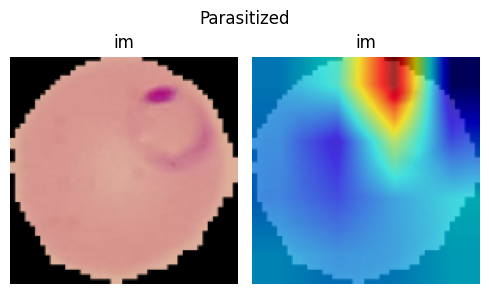

torch.Size([1, 64, 4, 4])


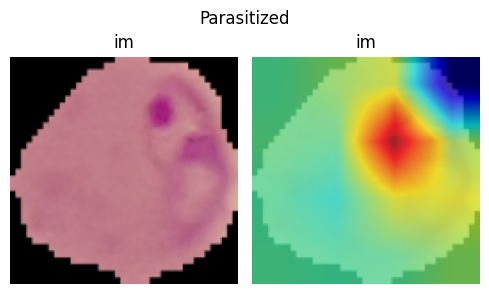

torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 4, 4])


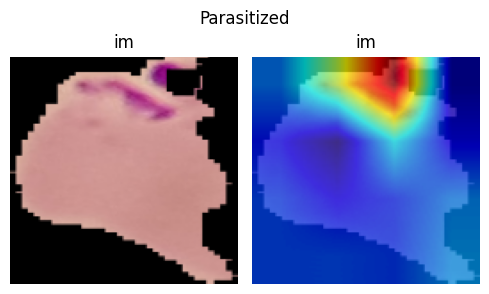

torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 4, 4])


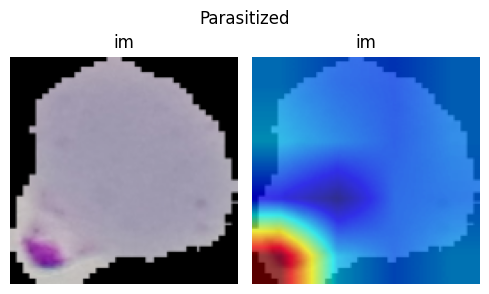

torch.Size([1, 64, 4, 4])


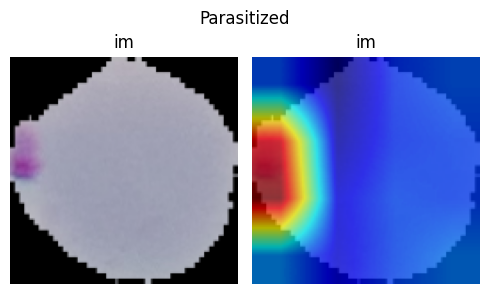

torch.Size([1, 64, 4, 4])


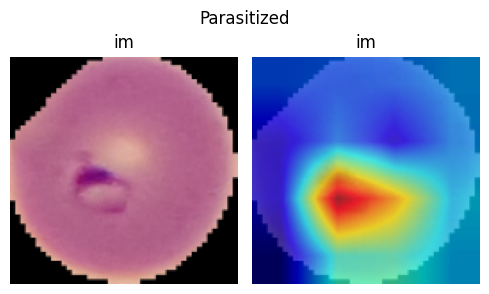

torch.Size([1, 64, 4, 4])


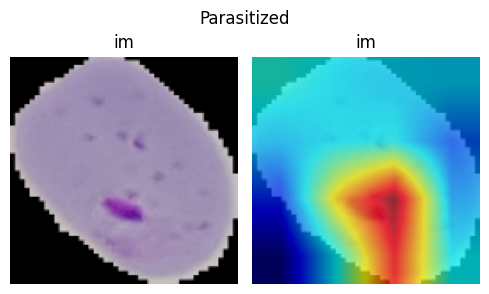

torch.Size([1, 64, 4, 4])


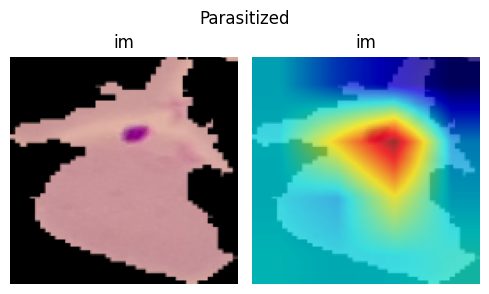

torch.Size([1, 64, 4, 4])


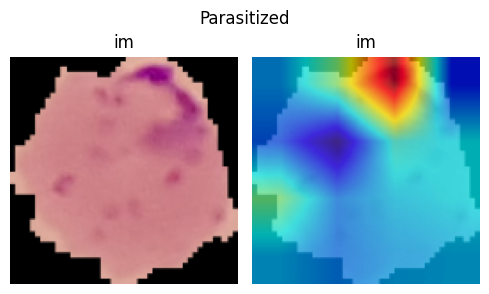

torch.Size([1, 64, 4, 4])


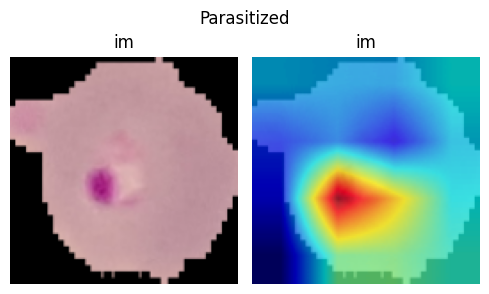

torch.Size([1, 64, 4, 4])


In [24]:
N = 20
_val_dl = DataLoader(val_ds, batch_size=N, shuffle=True, collate_fn=val_ds.collate_fn)
x,y,z = next(iter(_val_dl))

for i in range(N):
    image = resize(z[i], SZ)
    heatmap, pred = im2gradCAM(x[i:i+1])
    if(pred=='Uninfected'):
        continue
    heatmap = upsampleHeatmap(heatmap, image)
    subplots([image, heatmap], nc=2, figsize=(5,3), suptitle=pred)